In [10]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC

### Week 4 Work

In [11]:
data = pd.read_parquet("./dsc-capstone-2022/DSC180B.parquet")
data['dt'] = pd.to_datetime(data['transaction_date'])
data = data[["amount", "dt", "new_category"]]
data

,amount,dt,new_category
8,15.25,2018-03-06,Entertainment
39,16.04,2018-09-29,General Merchandise
45,10.36,2018-10-17,Automotive
52,4.63,2017-07-11,Automotive
55,223.00,2018-09-10,General Merchandise
...,...,...,...
1999981,24.24,2021-02-19,Automotive
1999982,120.60,2021-01-19,General Merchandise
1999983,6.47,2022-02-25,Food and Beverages
1999991,44.98,2021-01-11,General Merchandise


In [12]:
data.dtypes

amount                 float64
dt              datetime64[ns]
new_category            object
dtype: object

In [13]:
data['new_category'].value_counts()

Food and Beverages     162009
General Merchandise    138971
Automotive              63617
Groceries               63541
Entertainment           31492
Travel                  25491
Healthcare/Medical       8392
Pets/Pet Care            2588
Name: new_category, dtype: int64

In [14]:
# step 1: try to make a model without the text column

In [15]:
data['year'] = data['dt'].dt.year # ranges 2010 - 2022
data['month'] = data['dt'].dt.month # ranges 1 - 12
data['is_holiday'] = data['month'].apply(lambda x: 1 if x == 11 or x == 12 else 0) # 0 or 1
data['day'] = data['dt'].dt.dayofweek # to be discarded
data['is_weekend'] = data['day'].apply(lambda x: 1 if x == 5 or x == 6 else 0) # 0 or 1

# amount: consider encoding whole numbers
data['is_whole_number'] = data['amount'].apply(lambda x: 1 if str(x).split(".")[1] == "0" else 0)
data

,amount,dt,new_category,year,month,is_holiday,day,is_weekend,is_whole_number
8,15.25,2018-03-06,Entertainment,2018,3,0,1,0,0
39,16.04,2018-09-29,General Merchandise,2018,9,0,5,1,0
45,10.36,2018-10-17,Automotive,2018,10,0,2,0,0
52,4.63,2017-07-11,Automotive,2017,7,0,1,0,0
55,223.00,2018-09-10,General Merchandise,2018,9,0,0,0,1
...,...,...,...,...,...,...,...,...,...
1999981,24.24,2021-02-19,Automotive,2021,2,0,4,0,0
1999982,120.60,2021-01-19,General Merchandise,2021,1,0,1,0,0
1999983,6.47,2022-02-25,Food and Beverages,2022,2,0,4,0,0
1999991,44.98,2021-01-11,General Merchandise,2021,1,0,0,0,0


In [22]:
# X y split
X = data[["amount", "is_whole_number", "year", "month", "day", "is_holiday", "is_weekend"]]
y = data[["new_category"]]

# standard scale: amount
scaler = StandardScaler()
scaler_df = pd.DataFrame(scaler.fit_transform(X[['amount']]), index = X.index)

# one hot encode: year, month, day
ohe = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(ohe.fit_transform(X[['year']]).toarray(), columns = pd.Series(X['year'].unique()).sort_values().values, index = X.index)

ohe2 = OneHotEncoder(handle_unknown='ignore')
encoder_df2 = pd.DataFrame(ohe2.fit_transform(X[['month']]).toarray(), columns = pd.Series(X['month'].unique()).sort_values().values, index = X.index)

# monday = 0, sunday = 6
def convert_date_to_day(date):
    if date == 0:
        return "monday"
    if date == 1:
        return "tuesday"
    if date == 2:
        return "wednesday"
    if date == 3:
        return "thursday"
    if date == 4:
        return "friday"
    if date == 5:
        return "saturday"
    if date == 6:
        return "sunday"

X['day_word'] = X['day'].apply(convert_date_to_day)
ohe3 = OneHotEncoder(handle_unknown='ignore')
encoder_df3 = pd.DataFrame(ohe3.fit_transform(X[['day_word']]).toarray(), columns = pd.Series(X['day_word'].unique()).sort_values().values, index = X.index)

# combine features and remove duplicate features
X = pd.concat([X, scaler_df, encoder_df, encoder_df2, encoder_df3], axis=1)
X = X[[0, 'is_whole_number', 'is_holiday', 'is_weekend', 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, "monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]]
X.rename({0: "amount (standardized)"}, axis=1, inplace=True)

# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# train model
model = LogisticRegression(multi_class = "multinomial").fit(X_train, y_train)
model2 = SGDClassifier(loss="log").fit(X_train, y_train)

# predict and store predictions
preds = model.predict(X_test)
preds2 = model2.predict(X_test)

X

,amount (standardized),is_whole_number,is_holiday,is_weekend,2010,2011,2012,2013,2014,2015,...,10,11,12,monday,tuesday,wednesday,thursday,friday,saturday,sunday
8,-0.012686,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
39,-0.012246,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
45,-0.015409,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
52,-0.018601,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
55,0.103030,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999981,-0.007678,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1999982,0.045994,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1999983,-0.017576,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1999991,0.003874,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
y_test = np.array(y_test['new_category'])
accuracy = (preds == y_test).mean()
accuracy2 = (preds2 == y_test).mean()
print("Logistic Regression accuracy: {}, \nSGDClassifier accuracy: {}".format(accuracy, accuracy2)) # accuracy is for LogRes, accuracy2 is for SGDClassifier

Logistic Regression accuracy: 0.3368007623049953, 
SGDClassifier accuracy: 0.335371440438814


### EDA

In [25]:
data['day'].value_counts()
# interesting -- most transactions are from monday and very few are from sat or sun

0    171457
1     88338
4     75212
3     66831
2     66318
5     15748
6     12197
Name: day, dtype: int64

In [26]:
data['year'].value_counts().sort_index()
# mostly from 2017-2022

2010         3
2011        12
2012        71
2013       166
2014       833
2015      2158
2016      5411
2017     38478
2018    138066
2019     82166
2020     70541
2021    105667
2022     52529
Name: year, dtype: int64

### Checking if there is a difference between November/December and rest of year

True


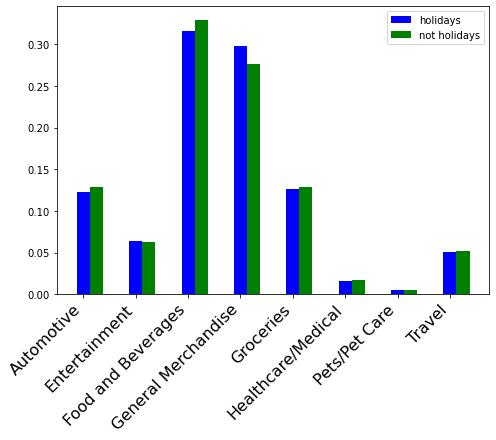

In [27]:
holidays = data[data['month'] >= 11]
not_holidays = data[data['month'] < 11]
print(len(holidays) + len(not_holidays) == len(data)) # proves proper split
holidays_vc = holidays['new_category'].value_counts(normalize=True, sort=False).sort_index()
not_holidays_vc = not_holidays['new_category'].value_counts(normalize=True, sort=False).sort_index()

X = np.arange(8)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, holidays_vc, color = 'b', width = 0.25)
ax.bar(X + 0.25, not_holidays_vc, color = 'g', width = 0.25)
plt.xticks(np.arange(8), holidays_vc.index, color='black', rotation=45, fontsize='16', horizontalalignment='right')
plt.legend(labels = ["holidays", "not holidays"])
plt.show()